In [2]:
import nibabel as nib
import numpy as np

from dmipy.core.acquisition_scheme import acquisition_scheme_from_bvalues
from dmipy.signal_models import cylinder_models, gaussian_models
from dmipy.core.modeling_framework import MultiCompartmentModel

import matplotlib.pyplot as plt

import config
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
from tqdm import tqdm

In [3]:
def squash(param, p_min, p_max):
    squashed_param_tensor =torch.clamp(param, min=p_min, max=p_max)
    unsqueezed_param = squashed_param_tensor.unsqueeze(1)
    return unsqueezed_param

In [90]:
def unitsphere2cart(theta, phi):
    mu_cart = torch.zeros(3,128)
    sintheta = torch.sin(theta)
    mu_cart[0,:] = torch.squeeze(sintheta * torch.cos(phi))
    mu_cart[1,:] = torch.squeeze(sintheta * torch.sin(phi))
    mu_cart[2,:] = torch.squeeze(torch.cos(theta))
    return mu_cart

In [5]:
def get_acquisition_scheme():
    bvals = np.loadtxt(
        config.data_folder2 + '/100206/bvals'
    ) * 1e-3
    # s/m^2
    gradient_directions = np.loadtxt(
        config.data_folder2 + '/100206/bvecs'
    ).T

    delta = 0.0106
    Delta = 0.0431
    return acquisition_scheme_from_bvalues(bvals, gradient_directions, delta, Delta)

In [6]:
class BallStickNet(nn.Module):
    
    def __init__(self, gradient_directions, b_values):
        super(BallStickNet, self).__init__()
        self.gradient_directions = gradient_directions
        self.b_values = b_values
        self.fc_layers = nn.ModuleList()
        for i in range(3): 
            self.fc_layers.extend([nn.Linear(len(b_values), len(b_values)), nn.ELU()])
        self.encoder = nn.Sequential(*self.fc_layers, nn.Linear(len(b_values), 5))
        # if args.dropout != 0:
        #     self.dropout = nn.Dropout(args.dropout)
            
    def forward(self, X):
        # if args.dropout != 0:
        #     X = self.dropout(X)
        params = torch.abs(self.encoder(X))
        theta_uns = params[:, 0]
        theta = squash(theta_uns, 0, np.pi)
        phi_uns = params[:, 1]
        phi = squash(phi_uns, -np.pi, np.pi)
        mu_cart = unitsphere2cart(theta, phi)
        mm_prod =  torch.einsum("ij,jk->ki",self.gradient_directions, mu_cart)
        lambda_par_uns = params[:, 2]
        lambda_par = squash(lambda_par_uns, 0.1, 3.0)
        lambda_iso_uns = params[:, 3]
        lambda_iso = squash(lambda_iso_uns, 0.1, 3.0)
        volume_0_uns = params[:, 4]
        volume_0 = squash(volume_0_uns, 0.01, 0.99)
        volume_1 = 1-volume_0
        X = volume_0 * torch.exp(-self.b_values * lambda_par * mm_prod ** 2) + volume_1 * torch.exp(-self.b_values * lambda_iso)
        return X, mu_cart, lambda_par, lambda_iso, volume_0, volume_1

**Construct ball-stick model**

In [7]:
ball = gaussian_models.G1Ball()
stick = cylinder_models.C1Stick()
BAS_mod = MultiCompartmentModel(models=[stick, ball])

We highly recommend installing numba for faster function execution and model fitting.
We highly recommend installing pathos to take advantage of multicore processing.


In [141]:
BAS_mod.parameter_ranges

OrderedDict([('C1Stick_1_mu',
              ([0, 3.141592653589793],
               [-3.141592653589793, 3.141592653589793])),
             ('C1Stick_1_lambda_par', (0.1, 3)),
             ('G1Ball_1_lambda_iso', (0.1, 3)),
             ('partial_volume_0', (0.01, 0.99)),
             ('partial_volume_1', (0.01, 0.99))])

In [142]:
BAS_mod.parameter_scales

OrderedDict([('C1Stick_1_mu', array([1., 1.])),
             ('C1Stick_1_lambda_par', 1e-09),
             ('G1Ball_1_lambda_iso', 1e-09),
             ('partial_volume_0', 1.0),
             ('partial_volume_1', 1.0)])

**Get scheme**

In [8]:
hcp_scheme = get_acquisition_scheme()

In [143]:
hcp_scheme.print_acquisition_info

Acquisition scheme summary

total number of measurements: 288
number of b0 measurements: 288
number of DWI shells: 0

shell_index |# of DWIs |bvalue [s/mm^2] |gradient strength [mT/m] |delta [ms] |Delta[ms] |TE[ms]
0           |288       |0               |0                        |10.6       |43.1      |N/A  


**Simulated data**

In [9]:
num_samples = 10000
simulated_x_train = np.zeros((num_samples, 288))
simulated_BAS_param_vec = np.zeros((num_samples, 6))

for i in range(len(simulated_x_train)):
    C1Stick_1_mu = (np.random.uniform(0, np.pi),np.random.uniform(-np.pi, np.pi))
    C1Stick_1_lambda_par = np.random.uniform(0.1, 3.0)
    G1Ball_1_lambda_iso = np.random.uniform(0.1, 3.0)
    partial_volume_0 = np.random.uniform(0.01, 0.99)
    partial_volume_1 = 1 - partial_volume_0
    simulated_param_vec = BAS_mod.parameters_to_parameter_vector(C1Stick_1_lambda_par=C1Stick_1_lambda_par, C1Stick_1_mu=C1Stick_1_mu, G1Ball_1_lambda_iso=G1Ball_1_lambda_iso, partial_volume_0=partial_volume_0, partial_volume_1=partial_volume_1)
    simulated_BAS_param_vec[i, :] = simulated_param_vec
    E_simulated = BAS_mod.simulate_signal(hcp_scheme, simulated_param_vec)
    simulated_x_train[i, :] = E_simulated

In [11]:
print(simulated_x_train.shape)
print(simulated_BAS_param_vec.shape)

(10000, 288)
(10000, 6)


**NN object**

In [12]:
bvals = np.loadtxt(config.data_folder2 + '/100206/bvals') * 1e-3
n = np.loadtxt(config.data_folder2 + '/100206/bvecs').T
b_values = torch.FloatTensor(bvals)
gradient_directions = torch.FloatTensor(n)

net = BallStickNet(gradient_directions, b_values)

**Loss function and optimizer**

In [13]:
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.0001)

**Training data loader**

In [14]:
batch_size = 128
num_batches = len(simulated_x_train) // batch_size
trainloader = utils.DataLoader(torch.from_numpy(simulated_x_train.astype(np.float32)),
                               batch_size = batch_size, 
                               shuffle = True,
                               num_workers = 2,
                               drop_last = True)

In [15]:
print(num_batches)
print(len(trainloader))

78
78


**Train**

In [17]:
loss_arr=[]
avg_loss_arr=[]

counter = 0

# Best loss
best = 1e16
num_bad_epochs = 0
patience = 10

for epoch in range(1000):
    print("-----------------------------------------------------------------")
    print("Epoch: {}; Bad epochs: {}".format(epoch, num_bad_epochs))
    net.train()
    running_loss = 0.

    for i, X_batch in enumerate(tqdm(trainloader), 0):
        optimizer.zero_grad()
        X_pred, mu_cart_pred, lambda_par_pred, lambda_iso_pred,  volume_0_pred, volume_1_pred = net(X_batch)
        if i == 8 and counter == 10:
            print("X_batch: ")
            print(X_batch.shape)
            print(X_batch)
            print("X_pred: ")
            print(X_pred.shape)
            print(X_pred)
        loss = criterion(X_pred.type(torch.FloatTensor), X_batch.type(torch.FloatTensor))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    loss_arr.append(running_loss)
    avg_loss_arr.append(running_loss/len(trainloader))
    print("Loss: {}".format(running_loss))
    print("Average Loss: {}".format(running_loss/num_batches))
    

    if running_loss < best:
        print("############### Saving good model ###############################")
        final_model = net.state_dict()
        best = running_loss
        num_bad_epochs = 0
    else:
        num_bad_epochs = num_bad_epochs + 1
        if num_bad_epochs == patience:
            print("Done, best loss: {}".format(best))
            break
    counter += 1
print("Done")
net.load_state_dict(final_model)


-----------------------------------------------------------------
Epoch: 0; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 31.37it/s]


Loss: 8.389103502035141
Average Loss: 0.10755260900045052
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 1; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:01<00:00, 42.19it/s]


Loss: 8.308790735900402
Average Loss: 0.10652295815256926
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 2; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:01<00:00, 40.95it/s]


Loss: 8.271563678979874
Average Loss: 0.10604568819204967
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 3; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:01<00:00, 39.47it/s]


Loss: 8.219923004508018
Average Loss: 0.10538362826292332
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 4; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:01<00:00, 42.10it/s]


Loss: 8.171096973121166
Average Loss: 0.10475765350155342
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 5; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:01<00:00, 42.19it/s]


Loss: 8.123440846800804
Average Loss: 0.10414667752308723
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 6; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 37.27it/s]


Loss: 8.072400018572807
Average Loss: 0.10349230793042061
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 7; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 37.90it/s]


Loss: 8.039921417832375
Average Loss: 0.10307591561323558
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 8; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 37.99it/s]


Loss: 8.018177755177021
Average Loss: 0.1027971507073977
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 9; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 33.24it/s]


Loss: 7.981645084917545
Average Loss: 0.10232878313996853
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 10; Bad epochs: 0


 59%|████████████████████████████████████▌                         | 46/78 [00:01<00:00, 41.61it/s]

X_batch: 
torch.Size([128, 288])
tensor([[0.9958, 0.7908, 0.2663,  ..., 0.2301, 0.7975, 0.0215],
        [0.9932, 0.5189, 0.1522,  ..., 0.2508, 0.4412, 0.0256],
        [0.9972, 0.7451, 0.5434,  ..., 0.6094, 0.5625, 0.4483],
        ...,
        [0.9865, 0.1416, 0.0065,  ..., 0.1367, 0.0840, 0.0023],
        [0.9954, 0.4500, 0.2127,  ..., 0.4283, 0.2803, 0.1095],
        [0.9994, 0.8289, 0.3366,  ..., 0.9410, 0.9134, 0.2292]])
X_pred: 
torch.Size([128, 288])
tensor([[9.9639e-01, 8.8644e-01, 2.5716e-01,  ..., 1.7760e-01, 9.6500e-01,
         1.1431e-02],
        [9.9698e-01, 9.8140e-01, 7.3071e-02,  ..., 1.4746e-01, 9.0681e-01,
         1.7370e-03],
        [9.9981e-01, 6.2741e-01, 4.8466e-02,  ..., 4.4407e-01, 8.5094e-01,
         4.5993e-03],
        ...,
        [9.9985e-01, 6.8746e-01, 2.3436e-02,  ..., 4.5410e-01, 9.4051e-01,
         9.3900e-04],
        [9.9987e-01, 7.1065e-01, 2.3058e-02,  ..., 4.4343e-01, 9.5720e-01,
         1.2920e-03],
        [9.9929e-01, 5.2815e-01, 2.0835

100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 37.30it/s]


Loss: 7.941014721989632
Average Loss: 0.10180788105114913
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 11; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:01<00:00, 40.02it/s]


Loss: 7.8957862332463264
Average Loss: 0.10122802863136315
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 12; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 38.49it/s]


Loss: 7.869951270520687
Average Loss: 0.10089681116052163
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 13; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 38.45it/s]


Loss: 7.845442421734333
Average Loss: 0.10058259515044017
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 14; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 38.88it/s]


Loss: 7.8124135956168175
Average Loss: 0.10015914866175407
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 15; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:01<00:00, 39.28it/s]


Loss: 7.798204742372036
Average Loss: 0.09997698387656456
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 16; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 38.74it/s]


Loss: 7.750452868640423
Average Loss: 0.09936478036718491
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 17; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:01<00:00, 39.75it/s]


Loss: 7.721780560910702
Average Loss: 0.09899718667834233
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 18; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:01<00:00, 39.11it/s]


Loss: 7.689962908625603
Average Loss: 0.0985892680593026
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 19; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:01<00:00, 39.70it/s]


Loss: 7.668904982507229
Average Loss: 0.09831929464752857
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 20; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:01<00:00, 39.82it/s]


Loss: 7.639229714870453
Average Loss: 0.09793884249833915
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 21; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:01<00:00, 40.55it/s]


Loss: 7.61528941988945
Average Loss: 0.09763191563960834
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 22; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:01<00:00, 40.11it/s]


Loss: 7.583724640309811
Average Loss: 0.09722723897833091
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 23; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:01<00:00, 39.64it/s]


Loss: 2.786332007497549
Average Loss: 0.03572220522432755
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 24; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:01<00:00, 40.95it/s]


Loss: 1.172494426369667
Average Loss: 0.015031979825252142
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 25; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:01<00:00, 40.35it/s]


Loss: 1.1017852639779449
Average Loss: 0.014125452102281345
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 26; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:01<00:00, 40.37it/s]


Loss: 1.0591740626841784
Average Loss: 0.013579154649797158
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 27; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:01<00:00, 40.72it/s]


Loss: 1.0365749122574925
Average Loss: 0.013289421952019135
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 28; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:01<00:00, 40.21it/s]


Loss: 1.0137383677065372
Average Loss: 0.0129966457398274
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 29; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:01<00:00, 40.25it/s]


Loss: 0.9854916529729962
Average Loss: 0.01263450837144867
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 30; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:01<00:00, 40.14it/s]


Loss: 0.9726053439080715
Average Loss: 0.012469299280872712
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 31; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:01<00:00, 40.99it/s]


Loss: 0.9557577213272452
Average Loss: 0.012253304119580068
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 32; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:01<00:00, 40.53it/s]


Loss: 0.9388602850958705
Average Loss: 0.01203667032174193
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 33; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:01<00:00, 41.05it/s]


Loss: 0.9288305668160319
Average Loss: 0.011908084189949127
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 34; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:01<00:00, 40.11it/s]


Loss: 0.9197288574650884
Average Loss: 0.011791395608526774
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 35; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:01<00:00, 39.72it/s]


Loss: 0.9139464255422354
Average Loss: 0.011717261865926094
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 36; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:01<00:00, 40.74it/s]


Loss: 0.903734396211803
Average Loss: 0.011586338412971834
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 37; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:01<00:00, 39.48it/s]


Loss: 0.8918923567980528
Average Loss: 0.01143451739484683
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 38; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:01<00:00, 40.69it/s]


Loss: 0.8675373625010252
Average Loss: 0.011122273878218273
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 39; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:01<00:00, 40.28it/s]


Loss: 0.8443340118974447
Average Loss: 0.010824795024326215
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 40; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:01<00:00, 39.86it/s]


Loss: 0.8202040158212185
Average Loss: 0.010515436100272032
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 41; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:01<00:00, 40.40it/s]


Loss: 0.7954115113243461
Average Loss: 0.010197583478517257
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 42; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:01<00:00, 40.22it/s]


Loss: 0.7809557737782598
Average Loss: 0.010012253509977689
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 43; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:01<00:00, 39.01it/s]


Loss: 0.7645220160484314
Average Loss: 0.009801564308313223
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 44; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 38.30it/s]


Loss: 0.7506570853292942
Average Loss: 0.009623808786273003
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 45; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 38.32it/s]


Loss: 0.7395920203998685
Average Loss: 0.009481948979485493
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 46; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 38.50it/s]


Loss: 0.7273633670993149
Average Loss: 0.00932517137306814
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 47; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 36.78it/s]


Loss: 0.7188435555435717
Average Loss: 0.009215943019789381
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 48; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 38.19it/s]


Loss: 0.711789729539305
Average Loss: 0.009125509353068013
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 49; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 38.47it/s]


Loss: 0.7019827235490084
Average Loss: 0.008999778507038569
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 50; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 38.21it/s]


Loss: 0.6936908392235637
Average Loss: 0.008893472297737995
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 51; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 38.35it/s]


Loss: 0.6847790163010359
Average Loss: 0.008779218157705588
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 52; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 38.75it/s]


Loss: 0.6748348330147564
Average Loss: 0.008651728628394313
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 53; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 38.51it/s]


Loss: 0.6710604405961931
Average Loss: 0.008603338982002476
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 54; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 38.85it/s]


Loss: 0.6606749836355448
Average Loss: 0.008470192097891599
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 55; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 38.78it/s]


Loss: 0.6498296302743256
Average Loss: 0.008331149106081098
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 56; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:01<00:00, 39.04it/s]


Loss: 0.6528403032571077
Average Loss: 0.008369747477655228
-----------------------------------------------------------------
Epoch: 57; Bad epochs: 1


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 37.46it/s]


Loss: 0.6410766136832535
Average Loss: 0.008218930944657097
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 58; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 38.81it/s]


Loss: 0.6306325504556298
Average Loss: 0.0080850326981491
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 59; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 36.85it/s]


Loss: 0.6203550659120083
Average Loss: 0.007953270075794978
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 60; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 38.12it/s]


Loss: 0.6167903244495392
Average Loss: 0.00790756826217358
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 61; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:01<00:00, 39.14it/s]


Loss: 0.6093713836744428
Average Loss: 0.00781245363685183
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 62; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:01<00:00, 39.28it/s]


Loss: 0.6029095849953592
Average Loss: 0.0077296100640430665
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 63; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:01<00:00, 39.32it/s]


Loss: 0.593226763419807
Average Loss: 0.007605471325894961
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 64; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 38.71it/s]


Loss: 0.5857206750661135
Average Loss: 0.007509239423924532
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 65; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 38.79it/s]


Loss: 0.5803166530095041
Average Loss: 0.007439957089865437
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 66; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 38.91it/s]


Loss: 0.5727239497937262
Average Loss: 0.007342614740945208
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 67; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:01<00:00, 39.21it/s]


Loss: 0.5672460999339819
Average Loss: 0.007272385896589511
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 68; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:01<00:00, 39.34it/s]


Loss: 0.5579163110814989
Average Loss: 0.007152773218993575
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 69; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:01<00:00, 39.09it/s]


Loss: 0.5553484288975596
Average Loss: 0.007119851652532816
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 70; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:01<00:00, 39.16it/s]


Loss: 0.5463835028931499
Average Loss: 0.007004916703758331
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 71; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:01<00:00, 39.31it/s]


Loss: 0.5421416074968874
Average Loss: 0.006950533429447275
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 72; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:01<00:00, 39.07it/s]


Loss: 0.5318312966264784
Average Loss: 0.006818349956749723
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 73; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:01<00:00, 39.48it/s]


Loss: 0.5238697729073465
Average Loss: 0.006716279139837775
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 74; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 38.59it/s]


Loss: 0.5236220955848694
Average Loss: 0.006713103789549608
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 75; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:01<00:00, 39.13it/s]


Loss: 0.5151829393580556
Average Loss: 0.00660490947894943
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 76; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:01<00:00, 39.36it/s]


Loss: 0.5088867843151093
Average Loss: 0.0065241895425014
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 77; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:01<00:00, 39.38it/s]


Loss: 0.5029440461657941
Average Loss: 0.006448000591869156
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 78; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:01<00:00, 39.19it/s]


Loss: 0.4985892870463431
Average Loss: 0.006392170346747988
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 79; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 38.98it/s]


Loss: 0.4941425919532776
Average Loss: 0.006335161435298431
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 80; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:01<00:00, 39.08it/s]


Loss: 0.484470066614449
Average Loss: 0.006211154700185244
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 81; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:01<00:00, 39.44it/s]


Loss: 0.4852137337438762
Average Loss: 0.0062206888941522594
-----------------------------------------------------------------
Epoch: 82; Bad epochs: 1


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 38.99it/s]


Loss: 0.47773672081530094
Average Loss: 0.00612482975404232
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 83; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:01<00:00, 39.09it/s]


Loss: 0.46666932315565646
Average Loss: 0.005982940040457134
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 84; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 38.31it/s]


Loss: 0.47039327025413513
Average Loss: 0.006030682951976092
-----------------------------------------------------------------
Epoch: 85; Bad epochs: 1


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 39.00it/s]


Loss: 0.4649267215281725
Average Loss: 0.0059605989939509295
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 86; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:01<00:00, 39.27it/s]


Loss: 0.45823304541409016
Average Loss: 0.005874782633513977
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 87; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:01<00:00, 39.13it/s]


Loss: 0.45259683090262115
Average Loss: 0.005802523473110528
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 88; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:01<00:00, 39.18it/s]


Loss: 0.44636743096634746
Average Loss: 0.005722659371363429
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 89; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 37.88it/s]


Loss: 0.441142339957878
Average Loss: 0.0056556710251009995
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 90; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 38.15it/s]


Loss: 0.43791516846977174
Average Loss: 0.00561429703166374
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 91; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:01<00:00, 39.35it/s]


Loss: 0.43772989977151155
Average Loss: 0.005611921791942456
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 92; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:01<00:00, 39.30it/s]


Loss: 0.4326667785644531
Average Loss: 0.0055470099815955526
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 93; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:01<00:00, 39.10it/s]


Loss: 0.42592447879724205
Average Loss: 0.005460570240990283
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 94; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 38.90it/s]


Loss: 0.4239446057472378
Average Loss: 0.005435187253169715
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 95; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:01<00:00, 39.32it/s]


Loss: 0.4183201885316521
Average Loss: 0.005363079340149386
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 96; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:01<00:00, 39.40it/s]


Loss: 0.4170772812794894
Average Loss: 0.0053471446317883255
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 97; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:01<00:00, 39.20it/s]


Loss: 0.40898808697238564
Average Loss: 0.005243437012466483
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 98; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 36.36it/s]


Loss: 0.4055851974990219
Average Loss: 0.005199810224346435
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 99; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 38.45it/s]


Loss: 0.40372261009179056
Average Loss: 0.0051759308986126995
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 100; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 35.43it/s]


Loss: 0.39856209186837077
Average Loss: 0.005109770408568856
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 101; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 33.70it/s]


Loss: 0.396859263535589
Average Loss: 0.005087939276097295
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 102; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 33.53it/s]


Loss: 0.39469227474182844
Average Loss: 0.00506015736848498
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 103; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 38.25it/s]


Loss: 0.38550516590476036
Average Loss: 0.004942373921855902
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 104; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 37.90it/s]


Loss: 0.3854733023326844
Average Loss: 0.0049419654145215946
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 105; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 38.11it/s]


Loss: 0.3811835946980864
Average Loss: 0.0048869691627959795
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 106; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 38.44it/s]


Loss: 0.3816883987747133
Average Loss: 0.004893441009932222
-----------------------------------------------------------------
Epoch: 107; Bad epochs: 1


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 38.60it/s]


Loss: 0.37469102372415364
Average Loss: 0.004803731073386585
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 108; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 38.67it/s]


Loss: 0.3778654143679887
Average Loss: 0.0048444283893331885
-----------------------------------------------------------------
Epoch: 109; Bad epochs: 1


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 38.75it/s]


Loss: 0.37100505270063877
Average Loss: 0.0047564750346235736
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 110; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 38.82it/s]


Loss: 0.3704338769894093
Average Loss: 0.0047491522690949915
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 111; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 38.83it/s]


Loss: 0.3674453014973551
Average Loss: 0.0047108371986840395
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 112; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 38.83it/s]


Loss: 0.3639329746365547
Average Loss: 0.004665807367135317
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 113; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 38.67it/s]


Loss: 0.3594564185477793
Average Loss: 0.004608415622407427
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 114; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 38.95it/s]


Loss: 0.35355157288722694
Average Loss: 0.004532712472913166
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 115; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 38.88it/s]


Loss: 0.35385917755775154
Average Loss: 0.004536656122535276
-----------------------------------------------------------------
Epoch: 116; Bad epochs: 1


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 38.91it/s]


Loss: 0.350830647861585
Average Loss: 0.00449782881873827
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 117; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 38.60it/s]


Loss: 0.3493379659485072
Average Loss: 0.004478691871134708
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 118; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 37.91it/s]


Loss: 0.3526181902270764
Average Loss: 0.004520746028552262
-----------------------------------------------------------------
Epoch: 119; Bad epochs: 1


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 38.70it/s]


Loss: 0.3460095631889999
Average Loss: 0.004436020040884614
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 120; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 38.89it/s]


Loss: 0.3466804053168744
Average Loss: 0.004444620580985569
-----------------------------------------------------------------
Epoch: 121; Bad epochs: 1


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 38.52it/s]


Loss: 0.33976463275030255
Average Loss: 0.004355956830132084
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 122; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 38.82it/s]


Loss: 0.341746979393065
Average Loss: 0.00438137153068032
-----------------------------------------------------------------
Epoch: 123; Bad epochs: 1


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 38.77it/s]


Loss: 0.34092044993303716
Average Loss: 0.004370774999141502
-----------------------------------------------------------------
Epoch: 124; Bad epochs: 2


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 38.37it/s]


Loss: 0.33825225895270705
Average Loss: 0.004336567422470603
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 125; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 38.90it/s]


Loss: 0.3354981418233365
Average Loss: 0.004301258228504314
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 126; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 38.56it/s]


Loss: 0.3350253324024379
Average Loss: 0.004295196569262025
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 127; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 38.63it/s]


Loss: 0.33093909989111125
Average Loss: 0.004242808972962965
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 128; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 38.64it/s]


Loss: 0.3322503827512264
Average Loss: 0.0042596202916823905
-----------------------------------------------------------------
Epoch: 129; Bad epochs: 1


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 38.48it/s]


Loss: 0.32880997005850077
Average Loss: 0.004215512436647446
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 130; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 38.67it/s]


Loss: 0.3276512483134866
Average Loss: 0.004200657029660084
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 131; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 38.34it/s]


Loss: 0.3277464851271361
Average Loss: 0.0042018780144504626
-----------------------------------------------------------------
Epoch: 132; Bad epochs: 1


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 38.34it/s]


Loss: 0.3202566185500473
Average Loss: 0.004105854083974965
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 133; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 38.76it/s]


Loss: 0.3166694692336023
Average Loss: 0.0040598649901743885
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 134; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 38.61it/s]


Loss: 0.32215437828563154
Average Loss: 0.004130184336995276
-----------------------------------------------------------------
Epoch: 135; Bad epochs: 1


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 38.63it/s]


Loss: 0.3201592480763793
Average Loss: 0.004104605744568965
-----------------------------------------------------------------
Epoch: 136; Bad epochs: 2


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 38.31it/s]


Loss: 0.3155376766808331
Average Loss: 0.00404535482924145
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 137; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 38.88it/s]


Loss: 0.31300999177619815
Average Loss: 0.004012948612515361
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 138; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 38.67it/s]


Loss: 0.3074422983918339
Average Loss: 0.003941567928100435
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 139; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 38.13it/s]


Loss: 0.30722181615419686
Average Loss: 0.003938741232746114
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 140; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 38.59it/s]


Loss: 0.30416949023492634
Average Loss: 0.0038996088491657223
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 141; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 38.31it/s]


Loss: 0.30160429142415524
Average Loss: 0.0038667216849250672
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 142; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 38.74it/s]


Loss: 0.30195717443712056
Average Loss: 0.0038712458261169302
-----------------------------------------------------------------
Epoch: 143; Bad epochs: 1


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 38.65it/s]


Loss: 0.3020571304950863
Average Loss: 0.003872527314039568
-----------------------------------------------------------------
Epoch: 144; Bad epochs: 2


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 38.74it/s]


Loss: 0.3023285542149097
Average Loss: 0.0038760071053193547
-----------------------------------------------------------------
Epoch: 145; Bad epochs: 3


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 38.12it/s]


Loss: 0.30574580654501915
Average Loss: 0.0039198180326284505
-----------------------------------------------------------------
Epoch: 146; Bad epochs: 4


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 38.52it/s]


Loss: 0.30080213234759867
Average Loss: 0.003856437594199983
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 147; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 38.70it/s]


Loss: 0.29843413131311536
Average Loss: 0.003826078606578402
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 148; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 38.06it/s]


Loss: 0.2976395192090422
Average Loss: 0.0038158912719107973
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 149; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 38.14it/s]


Loss: 0.29656197130680084
Average Loss: 0.0038020765552153955
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 150; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 38.36it/s]


Loss: 0.2944456471595913
Average Loss: 0.0037749441943537346
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 151; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 38.86it/s]


Loss: 0.29368132003583014
Average Loss: 0.003765145128664489
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 152; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 38.84it/s]


Loss: 0.28733553597703576
Average Loss: 0.0036837889227825096
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 153; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 38.66it/s]


Loss: 0.2860453163739294
Average Loss: 0.0036672476458196076
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 154; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 38.23it/s]


Loss: 0.28706546360626817
Average Loss: 0.0036803264564906177
-----------------------------------------------------------------
Epoch: 155; Bad epochs: 1


100%|██████████████████████████████████████████████████████████████| 78/78 [00:01<00:00, 39.13it/s]


Loss: 0.2831597903277725
Average Loss: 0.0036302537221509293
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 156; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:01<00:00, 39.74it/s]


Loss: 0.2822668273001909
Average Loss: 0.003618805478207576
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 157; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:01<00:00, 39.01it/s]


Loss: 0.27648848516400903
Average Loss: 0.0035447241687693466
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 158; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:01<00:00, 39.26it/s]


Loss: 0.2780973636545241
Average Loss: 0.003565350816083642
-----------------------------------------------------------------
Epoch: 159; Bad epochs: 1


100%|██████████████████████████████████████████████████████████████| 78/78 [00:01<00:00, 39.18it/s]


Loss: 0.27642230060882866
Average Loss: 0.0035438756488311365
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 160; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 38.97it/s]


Loss: 0.2792981171514839
Average Loss: 0.003580745091685691
-----------------------------------------------------------------
Epoch: 161; Bad epochs: 1


100%|██████████████████████████████████████████████████████████████| 78/78 [00:01<00:00, 39.19it/s]


Loss: 0.27211648714728653
Average Loss: 0.003488672912144699
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 162; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 38.47it/s]


Loss: 0.2716255516279489
Average Loss: 0.0034823788670249856
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 163; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:01<00:00, 39.00it/s]


Loss: 0.27279746101703495
Average Loss: 0.003497403346372243
-----------------------------------------------------------------
Epoch: 164; Bad epochs: 1


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 38.38it/s]


Loss: 0.2705192400608212
Average Loss: 0.003468195385395143
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 165; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 38.31it/s]


Loss: 0.2686534665990621
Average Loss: 0.0034442752128084884
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 166; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 38.62it/s]


Loss: 0.2765401132637635
Average Loss: 0.0035453860674841474
-----------------------------------------------------------------
Epoch: 167; Bad epochs: 1


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 38.32it/s]


Loss: 0.2750266878865659
Average Loss: 0.0035259831780328965
-----------------------------------------------------------------
Epoch: 168; Bad epochs: 2


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 38.45it/s]


Loss: 0.266186019172892
Average Loss: 0.003412641271447333
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 169; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 38.13it/s]


Loss: 0.2650760868564248
Average Loss: 0.003398411369954164
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 170; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 38.61it/s]


Loss: 0.2662692063022405
Average Loss: 0.0034137077731056474
-----------------------------------------------------------------
Epoch: 171; Bad epochs: 1


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 38.54it/s]


Loss: 0.2699354919604957
Average Loss: 0.0034607114353909707
-----------------------------------------------------------------
Epoch: 172; Bad epochs: 2


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 38.44it/s]


Loss: 0.25973291718401015
Average Loss: 0.003329909194666797
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 173; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 38.32it/s]


Loss: 0.25991138454992324
Average Loss: 0.0033321972378195287
-----------------------------------------------------------------
Epoch: 174; Bad epochs: 1


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 37.57it/s]


Loss: 0.26058375695720315
Average Loss: 0.00334081739688722
-----------------------------------------------------------------
Epoch: 175; Bad epochs: 2


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 38.18it/s]


Loss: 0.2600193237885833
Average Loss: 0.003333581074212606
-----------------------------------------------------------------
Epoch: 176; Bad epochs: 3


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 37.92it/s]


Loss: 0.25882085179910064
Average Loss: 0.0033182160487064184
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 177; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 37.95it/s]


Loss: 0.2535495071206242
Average Loss: 0.003250634706674669
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 178; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 36.00it/s]


Loss: 0.2547988402657211
Average Loss: 0.0032666517982784756
-----------------------------------------------------------------
Epoch: 179; Bad epochs: 1


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 37.61it/s]


Loss: 0.25480165239423513
Average Loss: 0.003266687851208143
-----------------------------------------------------------------
Epoch: 180; Bad epochs: 2


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 37.31it/s]


Loss: 0.253765040775761
Average Loss: 0.003253397958663603
-----------------------------------------------------------------
Epoch: 181; Bad epochs: 3


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 38.40it/s]


Loss: 0.24933044449426234
Average Loss: 0.0031965441601828504
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 182; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 38.51it/s]


Loss: 0.25134229147806764
Average Loss: 0.0032223370702316365
-----------------------------------------------------------------
Epoch: 183; Bad epochs: 1


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 38.42it/s]


Loss: 0.2500775814987719
Average Loss: 0.003206122839727845
-----------------------------------------------------------------
Epoch: 184; Bad epochs: 2


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 38.62it/s]


Loss: 0.2469240624923259
Average Loss: 0.003165693108875973
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 185; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 38.35it/s]


Loss: 0.24997199815697968
Average Loss: 0.003204769207140765
-----------------------------------------------------------------
Epoch: 186; Bad epochs: 1


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 38.66it/s]


Loss: 0.24603769381064922
Average Loss: 0.0031543294078288362
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 187; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 38.72it/s]


Loss: 0.2428436283953488
Average Loss: 0.0031133798512224206
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 188; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 37.91it/s]


Loss: 0.2455092336749658
Average Loss: 0.003147554277884177
-----------------------------------------------------------------
Epoch: 189; Bad epochs: 1


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 37.86it/s]


Loss: 0.23977057717274874
Average Loss: 0.003073981758624984
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 190; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 38.03it/s]


Loss: 0.23891321336850524
Average Loss: 0.0030629899149808362
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 191; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 37.56it/s]


Loss: 0.24681925284676254
Average Loss: 0.0031643493954713144
-----------------------------------------------------------------
Epoch: 192; Bad epochs: 1


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 37.32it/s]


Loss: 0.2379245125921443
Average Loss: 0.00305031426400185
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 193; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 37.32it/s]


Loss: 0.23793319519609213
Average Loss: 0.0030504255794370785
-----------------------------------------------------------------
Epoch: 194; Bad epochs: 1


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 37.52it/s]


Loss: 0.24209115956909955
Average Loss: 0.0031037328149884557
-----------------------------------------------------------------
Epoch: 195; Bad epochs: 2


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 36.74it/s]


Loss: 0.23395252274349332
Average Loss: 0.0029993913172242734
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 196; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 36.73it/s]


Loss: 0.23776170832570642
Average Loss: 0.003048227029816749
-----------------------------------------------------------------
Epoch: 197; Bad epochs: 1


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 35.71it/s]


Loss: 0.235294577665627
Average Loss: 0.0030165971495593204
-----------------------------------------------------------------
Epoch: 198; Bad epochs: 2


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 35.83it/s]


Loss: 0.2379718255251646
Average Loss: 0.0030509208400662127
-----------------------------------------------------------------
Epoch: 199; Bad epochs: 3


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 35.80it/s]


Loss: 0.23859361559152603
Average Loss: 0.003058892507583667
-----------------------------------------------------------------
Epoch: 200; Bad epochs: 4


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 31.30it/s]


Loss: 0.22940862423274666
Average Loss: 0.0029411362081121365
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 201; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 32.65it/s]


Loss: 0.2351764990016818
Average Loss: 0.003015083320534382
-----------------------------------------------------------------
Epoch: 202; Bad epochs: 1


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 33.25it/s]


Loss: 0.23682866664603353
Average Loss: 0.0030362649570004297
-----------------------------------------------------------------
Epoch: 203; Bad epochs: 2


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 34.26it/s]


Loss: 0.22832578688394278
Average Loss: 0.0029272536779992664
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 204; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 33.22it/s]


Loss: 0.22834984655492008
Average Loss: 0.002927562135319488
-----------------------------------------------------------------
Epoch: 205; Bad epochs: 1


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 33.34it/s]


Loss: 0.22808460460510105
Average Loss: 0.0029241615975012956
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 206; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 33.18it/s]


Loss: 0.22617063741199672
Average Loss: 0.0028996235565640605
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 207; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 33.67it/s]


Loss: 0.23224763455800712
Average Loss: 0.0029775337763847066
-----------------------------------------------------------------
Epoch: 208; Bad epochs: 1


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 33.17it/s]


Loss: 0.2247956688515842
Average Loss: 0.0028819957545074895
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 209; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 33.30it/s]


Loss: 0.227863508509472
Average Loss: 0.002921327032172718
-----------------------------------------------------------------
Epoch: 210; Bad epochs: 1


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 33.42it/s]


Loss: 0.22766892926301807
Average Loss: 0.0029188324264489496
-----------------------------------------------------------------
Epoch: 211; Bad epochs: 2


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 29.57it/s]


Loss: 0.22984780673868954
Average Loss: 0.0029467667530601225
-----------------------------------------------------------------
Epoch: 212; Bad epochs: 3


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 28.19it/s]


Loss: 0.22758934856392443
Average Loss: 0.0029178121610759543
-----------------------------------------------------------------
Epoch: 213; Bad epochs: 4


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 27.14it/s]


Loss: 0.22457259462680668
Average Loss: 0.0028791358285488035
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 214; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 28.63it/s]


Loss: 0.22055924008600414
Average Loss: 0.0028276825652051815
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 215; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 30.25it/s]


Loss: 0.2231524217640981
Average Loss: 0.002860928484155104
-----------------------------------------------------------------
Epoch: 216; Bad epochs: 1


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 31.47it/s]


Loss: 0.22073004208505154
Average Loss: 0.0028298723344237376
-----------------------------------------------------------------
Epoch: 217; Bad epochs: 2


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 28.44it/s]


Loss: 0.2166974354768172
Average Loss: 0.0027781722497027847
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 218; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 28.13it/s]


Loss: 0.2173514987807721
Average Loss: 0.0027865576766765653
-----------------------------------------------------------------
Epoch: 219; Bad epochs: 1


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 27.94it/s]


Loss: 0.21628510451409966
Average Loss: 0.00277288595530897
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 220; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 30.78it/s]


Loss: 0.2132147279335186
Average Loss: 0.002733522152993828
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 221; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 30.87it/s]


Loss: 0.21449447225313634
Average Loss: 0.002749929131450466
-----------------------------------------------------------------
Epoch: 222; Bad epochs: 1


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 30.79it/s]


Loss: 0.21782633976545185
Average Loss: 0.002792645381608357
-----------------------------------------------------------------
Epoch: 223; Bad epochs: 2


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 30.43it/s]


Loss: 0.2109171401243657
Average Loss: 0.002704065899030329
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 224; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 29.20it/s]


Loss: 0.21349144191481173
Average Loss: 0.002737069768138612
-----------------------------------------------------------------
Epoch: 225; Bad epochs: 1


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 29.34it/s]


Loss: 0.21596947242505848
Average Loss: 0.0027688393900648523
-----------------------------------------------------------------
Epoch: 226; Bad epochs: 2


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 32.08it/s]


Loss: 0.20907589828129858
Average Loss: 0.0026804602343756226
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 227; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 32.31it/s]


Loss: 0.21295408462174237
Average Loss: 0.0027301805720736203
-----------------------------------------------------------------
Epoch: 228; Bad epochs: 1


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 32.16it/s]


Loss: 0.21214139240328223
Average Loss: 0.0027197614410677208
-----------------------------------------------------------------
Epoch: 229; Bad epochs: 2


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 32.37it/s]


Loss: 0.21295192756224424
Average Loss: 0.00273015291746467
-----------------------------------------------------------------
Epoch: 230; Bad epochs: 3


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 30.88it/s]


Loss: 0.2075481133069843
Average Loss: 0.0026608732475254396
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 231; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 29.72it/s]


Loss: 0.21065323473885655
Average Loss: 0.002700682496652007
-----------------------------------------------------------------
Epoch: 232; Bad epochs: 1


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 28.36it/s]


Loss: 0.20825547084677964
Average Loss: 0.0026699419339330723
-----------------------------------------------------------------
Epoch: 233; Bad epochs: 2


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 32.64it/s]


Loss: 0.2109251080546528
Average Loss: 0.0027041680519827283
-----------------------------------------------------------------
Epoch: 234; Bad epochs: 3


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 31.71it/s]


Loss: 0.20876890292856842
Average Loss: 0.002676524396520108
-----------------------------------------------------------------
Epoch: 235; Bad epochs: 4


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 31.36it/s]


Loss: 0.20439747639466077
Average Loss: 0.002620480466598215
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 236; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 31.16it/s]


Loss: 0.21463576250243932
Average Loss: 0.0027517405449030683
-----------------------------------------------------------------
Epoch: 237; Bad epochs: 1


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 32.26it/s]


Loss: 0.20635947701521218
Average Loss: 0.0026456343207078483
-----------------------------------------------------------------
Epoch: 238; Bad epochs: 2


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 26.62it/s]


Loss: 0.2051460910588503
Average Loss: 0.0026300780904980805
-----------------------------------------------------------------
Epoch: 239; Bad epochs: 3


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 26.93it/s]


Loss: 0.20204927388112992
Average Loss: 0.0025903753061683322
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 240; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 28.58it/s]


Loss: 0.20204310456756502
Average Loss: 0.00259029621240468
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 241; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 30.07it/s]


Loss: 0.2043738455977291
Average Loss: 0.0026201775076631936
-----------------------------------------------------------------
Epoch: 242; Bad epochs: 1


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 30.68it/s]


Loss: 0.20301803422626108
Average Loss: 0.002602795310593091
-----------------------------------------------------------------
Epoch: 243; Bad epochs: 2


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 31.02it/s]


Loss: 0.1980319715803489
Average Loss: 0.0025388714305172935
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 244; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 31.94it/s]


Loss: 0.19971473247278482
Average Loss: 0.002560445288112626
-----------------------------------------------------------------
Epoch: 245; Bad epochs: 1


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 29.51it/s]


Loss: 0.2033799443161115
Average Loss: 0.002607435183539891
-----------------------------------------------------------------
Epoch: 246; Bad epochs: 2


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 31.57it/s]


Loss: 0.19868416129611433
Average Loss: 0.0025472328371296707
-----------------------------------------------------------------
Epoch: 247; Bad epochs: 3


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 29.40it/s]


Loss: 0.19769083429127932
Average Loss: 0.002534497875529222
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 248; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 29.30it/s]


Loss: 0.19775393034797162
Average Loss: 0.0025353067993329694
-----------------------------------------------------------------
Epoch: 249; Bad epochs: 1


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 28.86it/s]


Loss: 0.193954840535298
Average Loss: 0.0024866005196833075
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 250; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 30.54it/s]


Loss: 0.19751634960994124
Average Loss: 0.002532260892435144
-----------------------------------------------------------------
Epoch: 251; Bad epochs: 1


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 30.42it/s]


Loss: 0.200130308046937
Average Loss: 0.002565773180088936
-----------------------------------------------------------------
Epoch: 252; Bad epochs: 2


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 29.50it/s]


Loss: 0.19963932770770043
Average Loss: 0.002559478560355134
-----------------------------------------------------------------
Epoch: 253; Bad epochs: 3


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 27.56it/s]


Loss: 0.19910723029170185
Average Loss: 0.0025526567986115622
-----------------------------------------------------------------
Epoch: 254; Bad epochs: 4


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 28.86it/s]


Loss: 0.19492163707036525
Average Loss: 0.0024989953470559646
-----------------------------------------------------------------
Epoch: 255; Bad epochs: 5


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 30.90it/s]


Loss: 0.19361880281940103
Average Loss: 0.0024822923438384747
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 256; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 32.22it/s]


Loss: 0.19802492600865662
Average Loss: 0.002538781102675085
-----------------------------------------------------------------
Epoch: 257; Bad epochs: 1


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 32.55it/s]


Loss: 0.19546221278142184
Average Loss: 0.0025059258048900235
-----------------------------------------------------------------
Epoch: 258; Bad epochs: 2


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 30.30it/s]


Loss: 0.1957159845624119
Average Loss: 0.0025091792892616913
-----------------------------------------------------------------
Epoch: 259; Bad epochs: 3


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 31.98it/s]


Loss: 0.19270652334671468
Average Loss: 0.0024705964531630087
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 260; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 33.41it/s]


Loss: 0.19561349833384156
Average Loss: 0.002507865363254379
-----------------------------------------------------------------
Epoch: 261; Bad epochs: 1


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 33.27it/s]


Loss: 0.1951791241299361
Average Loss: 0.002502296463204309
-----------------------------------------------------------------
Epoch: 262; Bad epochs: 2


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 29.91it/s]


Loss: 0.19568477279972285
Average Loss: 0.002508779138457985
-----------------------------------------------------------------
Epoch: 263; Bad epochs: 3


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 34.57it/s]


Loss: 0.1927837283583358
Average Loss: 0.002471586261004305
-----------------------------------------------------------------
Epoch: 264; Bad epochs: 4


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 34.57it/s]


Loss: 0.18964724941179156
Average Loss: 0.002431374992458866
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 265; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 35.04it/s]


Loss: 0.1885329515207559
Average Loss: 0.0024170891220609727
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 266; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 35.84it/s]


Loss: 0.18494517158251256
Average Loss: 0.0023710919433655455
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 267; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 35.93it/s]


Loss: 0.1896469376515597
Average Loss: 0.0024313709955328167
-----------------------------------------------------------------
Epoch: 268; Bad epochs: 1


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 36.20it/s]


Loss: 0.18641014106106013
Average Loss: 0.0023898736033469248
-----------------------------------------------------------------
Epoch: 269; Bad epochs: 2


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 36.86it/s]


Loss: 0.19199818512424827
Average Loss: 0.0024615151939006187
-----------------------------------------------------------------
Epoch: 270; Bad epochs: 3


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 36.82it/s]


Loss: 0.1895282710902393
Average Loss: 0.002429849629362042
-----------------------------------------------------------------
Epoch: 271; Bad epochs: 4


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 37.26it/s]


Loss: 0.19150643807370216
Average Loss: 0.002455210744534643
-----------------------------------------------------------------
Epoch: 272; Bad epochs: 5


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 37.55it/s]


Loss: 0.19056633429136127
Average Loss: 0.002443158131940529
-----------------------------------------------------------------
Epoch: 273; Bad epochs: 6


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 37.65it/s]


Loss: 0.18748451280407608
Average Loss: 0.0024036476000522575
-----------------------------------------------------------------
Epoch: 274; Bad epochs: 7


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 37.74it/s]


Loss: 0.18720624269917607
Average Loss: 0.0024000800346048214
-----------------------------------------------------------------
Epoch: 275; Bad epochs: 8


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 36.57it/s]


Loss: 0.1859896150417626
Average Loss: 0.0023844822441251613
-----------------------------------------------------------------
Epoch: 276; Bad epochs: 9


100%|██████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 37.60it/s]

Loss: 0.18628512881696224
Average Loss: 0.002388270882268747
Done, best loss: 0.18494517158251256
Done


<All keys matched successfully>

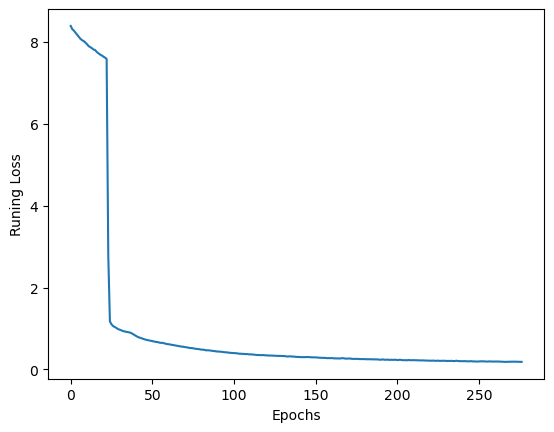

In [18]:
epoch_arr = np.arange(0, len(loss_arr))
loss_arr = np.array(loss_arr)
plt.plot(epoch_arr, loss_arr)
plt.xlabel("Epochs")
plt.ylabel("Runing Loss")
plt.show()

In [132]:
np.save("loss_for_simulated_data.npy", loss_arr)
np.save("avg_loss_for_simulated_data.npy", avg_loss_arr)

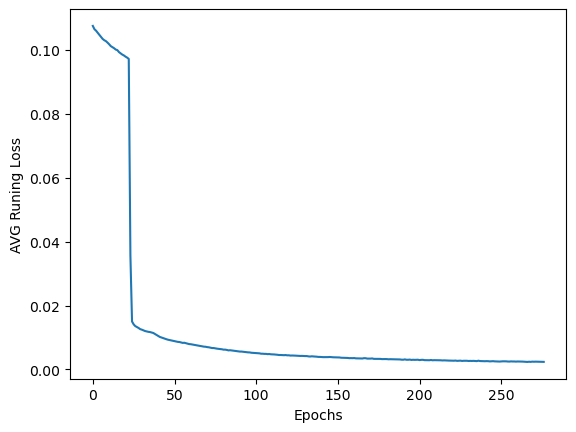

In [19]:
epoch_arr = np.arange(0, len(avg_loss_arr))
loss_arr = np.array(avg_loss_arr)
plt.plot(epoch_arr, avg_loss_arr)
plt.xlabel("Epochs")
plt.ylabel("AVG Runing Loss")
plt.show()

In [20]:
torch.save(final_model, 'model_simulated_data.pt')

In [24]:
net.eval()

BallStickNet(
  (fc_layers): ModuleList(
    (0): Linear(in_features=288, out_features=288, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=288, out_features=288, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=288, out_features=288, bias=True)
    (5): ELU(alpha=1.0)
  )
  (encoder): Sequential(
    (0): Linear(in_features=288, out_features=288, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=288, out_features=288, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=288, out_features=288, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=288, out_features=5, bias=True)
  )
)

In [37]:
X_pred_train, mu_cart_pred_train, lambda_par_pred_train, lambda_iso_pred_train,  volume_0_pred_train, volume_1_pred_train = net(torch.from_numpy(simulated_x_train[128:256,:].astype(np.float32)))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


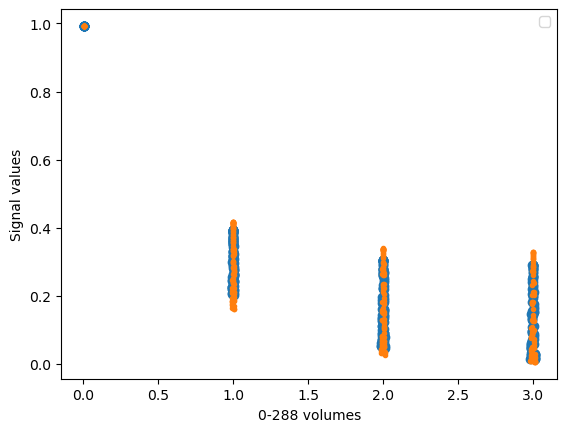

In [138]:
plt.plot(bvals, X_pred_train[3,:].detach().numpy(), 'o')
plt.plot(bvals, simulated_x_train[131,:], '.')
plt.xlabel("0-288 volumes")
plt.ylabel("Signal values")
plt.legend()

In [139]:
print(torch.min(lambda_par_pred_train))
print(torch.max(lambda_par_pred_train))

tensor(0.1000, grad_fn=<MinBackward1>)
tensor(2.7940, grad_fn=<MaxBackward1>)


In [122]:
mu_test = (np.random.uniform(0, np.pi),np.random.uniform(-np.pi, np.pi))
lambda_par_test = np.random.uniform(0.1, 3.0)
lambda_iso_test = np.random.uniform(0.1, 3.0)
volume_0_test = np.random.uniform(0.01, 0.99)
volume_1_test = 1 - volume_0_test
BAS_mod_param_vec_test = BAS_mod.parameters_to_parameter_vector(
    C1Stick_1_lambda_par=lambda_par_test, C1Stick_1_mu=mu_test, G1Ball_1_lambda_iso=lambda_iso_test, partial_volume_0=volume_0_test, partial_volume_1=volume_1_test)

In [123]:
E_test_ground_truth = BAS_mod.simulate_signal(hcp_scheme, BAS_mod_param_vec_test)

In [126]:
b_test = np.tile(E_test_ground_truth, (128, 1))

In [127]:
b_test.shape

(128, 288)

In [128]:
X_pred_test, mu_cart_pred_test, lambda_par_pred_test, lambda_iso_pred_test,  volume_0_pred_test, volume_1_pred_test = net(torch.from_numpy(b_test.astype(np.float32)))

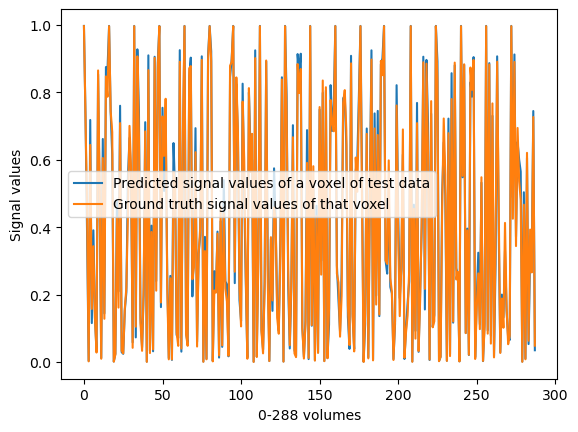

In [129]:
plt.plot(X_pred_test[0,:].detach().numpy(), label='Predicted signal values of a voxel of test data')
plt.plot(b_test[0,:], label='Ground truth signal values of that voxel')
plt.xlabel("0-288 volumes")
plt.ylabel("Signal values")
plt.legend()

In [87]:
normalized_scan_long_no_background_100206 = np.load('/Users/weiwenhua/UGY4/COMP0029/COMP0029-Project/deep-ivim/normalized_scan_long_1.npy')

In [89]:
normalized_scan_long_no_background_100206.shape

(935439, 288)

In [104]:
X_pred_test, mu_cart_pred_test, lambda_par_pred_test, lambda_iso_pred_test,  volume_0_pred_test, volume_1_pred_test = net(torch.from_numpy(normalized_scan_long_no_background_100206[0:128,:].astype(np.float32)))

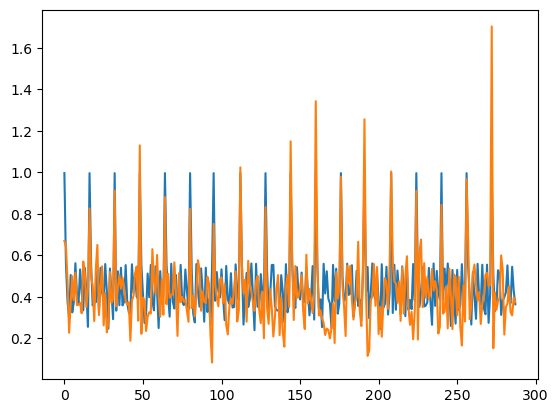

In [107]:
plt.plot(X_pred_test[100,:].detach().numpy())
plt.plot(normalized_scan_long_no_background_100206[100,:])

## Simulated Diffusion-Weighted MR Image

In [ ]:
# define parameter values in the three regions
S0_region0, S0_region1, S0_region2 = 4000, 2000, 1000
mu_region0, mu_region1, mu_region2 = (3.1,2.9), (2.3, 0.2), (0.2, -2.9)
lambda_par_region0, lambda_par_region1, lambda_par_region2 = 

C1Stick_1_mu = (np.random.uniform(0, np.pi),np.random.uniform(-np.pi, np.pi))
    C1Stick_1_lambda_par = np.random.uniform(0.1, 3.0)
    G1Ball_1_lambda_iso = np.random.uniform(0.1, 3.0)
    partial_volume_0 = np.random.uniform(0.01, 0.99)
    partial_volume_1 = 1 - partial_volume_0
    simulated_param_vec = BAS_mod.parameters_to_parameter_vector(C1Stick_1_lambda_par=C1Stick_1_lambda_par, C1Stick_1_mu=C1Stick_1_mu, G1Ball_1_lambda_iso=G1Ball_1_lambda_iso, partial_volume_0=partial_volume_0, partial_volume_1=partial_volume_1)
    simulated_BAS_param_vec[i, :] = simulated_param_vec
    E_simulated = BAS_mod.simulate_signal(hcp_scheme, simulated_param_vec)
# image size
sx, sy, sb = 100, 100, 288
# create image
dwi_image = np.zeros((sx, sy, sb))
Dp_truth = np.zeros((sx, sy))
Dt_truth = np.zeros((sx, sy))
Fp_truth = np.zeros((sx, sy))

# fill image with simulated values
for i in range(sx):
    for j in range(sy):
        if (40 < i < 60) and (40 < j < 60):
            # region 0
            
            dwi_image[i, j, :] = S0_region0*ivim(b_values, Dp_region0, Dt_region0, Fp_region0)
            Dp_truth[i, j], Dt_truth[i, j], Fp_truth[i, j] = Dp_region0, Dt_region0, Fp_region0
        elif (20 < i < 80) and (20 < j < 80):
            # region 1
            dwi_image[i, j, :] = S0_region1*ivim(b_values, Dp_region1, Dt_region1, Fp_region1)
            Dp_truth[i, j], Dt_truth[i, j], Fp_truth[i, j] = Dp_region1, Dt_region1, Fp_region1
        else:
            # region 2
            dwi_image[i, j, :] = S0_region2*ivim(b_values, Dp_region2, Dt_region2, Fp_region2)
            Dp_truth[i, j], Dt_truth[i, j], Fp_truth[i, j] = Dp_region2, Dt_region2, Fp_region2
# add some noise
dwi_image_real = dwi_image + np.random.normal(scale=15, size=(sx, sy, sb))
dwi_image_imag = np.random.normal(scale=15, size=(sx, sy, sb))
dwi_image = np.sqrt(dwi_image_real**2 + dwi_image_imag**2)
# plot simulated diffusion weighted image
fig, ax = plt.subplots(2, 4, figsize=(20,20))
b_id = 0
for i in range(2):
    for j in range(4):
        ax[i, j].imshow(dwi_image[:, :, b_id], cmap='gray', clim=(0, 1600))
        ax[i, j].set_title('b = ' + str(b_values[b_id]))
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        b_id += 1
plt.subplots_adjust(hspace=-0.6)
plt.show()

In [45]:
c = np.where(bvals==0.005)

In [47]:
c

(array([  0,  16,  32,  48,  64,  80,  95, 112, 128, 144, 160, 176, 191,
        208, 224, 240, 256, 272]),)

In [51]:
simulated_x_train[100,c]

array([[0.99760964, 0.99760771, 0.99760584, 0.99760581, 0.99760406,
        0.99760294, 0.99760425, 0.99760446, 0.99760264, 0.99760534,
        0.99760561, 0.99760697, 0.99760307, 0.99760474, 0.99760636,
        0.99760622, 0.99760784, 0.99760953]])

In [52]:
data_path = '/Users/weiwenhua/anaconda3/envs/deepNODDIEnv/lib/python3.10/site-packages/dmipy/data/hcp/100206/data.nii.gz'
data_100206 = nib.load(data_path).get_fdata()

In [101]:
data_100206[120, 100, 100, :]

array([1483.65722656,  404.93704224,  176.07182312,  178.24575806,
        302.21743774,  213.61386108,  361.13623047,  420.78726196,
        167.27963257,  184.37744141,  327.19561768,  300.33242798,
        215.56773376,  411.12402344,  184.34495544,  268.20150757,
       1479.14562988,  245.63964844,  247.88529968,  253.31460571,
        158.426651  ,  354.99893188,  332.04412842,  222.99026489,
        286.00024414,  169.31016541,  490.48910522,  243.00050354,
        254.56735229,  452.62866211,  278.65991211,  222.55412292,
       1307.54992676,  193.83006287,  504.06555176,  222.71235657,
        460.07839966,  291.07366943,  188.32446289,  433.62261963,
        236.77966309,  230.14982605,  259.65679932,  389.30563354,
        280.2315979 ,  455.19326782,  215.29463196,  221.58459473,
       1526.84997559,  257.45303345,  236.02700806,  237.00163269,
        216.15141296,  588.52478027,  249.67903137,  528.78570557,
        297.81491089,  394.37982178,  467.36309814,  278.05926